In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import os,sys, gc
import matplotlib.pyplot as plt
from scipy.stats import entropy
sys.path.append("/content/drive/My Drive/phd")
sys.path.append("/content/drive/My Drive/phd/hsbm-occam")
from hsbmpy import get_max_available_L

os.environ["TF_CUDNN_USE_AUTOTUNE"]="0"

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
algorithm = "topsbm"
directory='/content/drive/My Drive/phd/datasets/cancers/breast'
L = 1
os.chdir(directory)

In [4]:
label = 'Subtype_Selected_Lum'

df_topics = pd.read_csv("topsbm_all/%s_level_%d_topic-dist.csv"%(algorithm,L)).set_index('doc').drop('i_doc', axis=1)
df_words = pd.read_csv("topsbm_all/%s_level_%d_word-dist.csv"%(algorithm,L), index_col=0)
df_words.index=[g[:15] for g in df_words.index]
df = pd.read_csv("mainTable.csv", index_col=0).reindex(index=df_words.index)
df = df.divide(df.sum(0),1).transpose().fillna(0)
df_files=pd.read_csv("files.dat", index_col=0)
df_topics.insert(0,'tissue', df_files.reindex(index=df_topics.index)[label])
df_topic_tissue = df_topics.groupby('tissue').mean()
df_files.head()

,cases.0.submitter_id,cases.0.diagnoses.0.primary_diagnosis,cases.0.diagnoses.0.morphology,cases.0.diagnoses.0.tissue_or_organ_of_origin,cases.0.diagnoses.0.tumor_grade,cases.0.diagnoses.0.tumor_stage,cases.0.project.disease_type,cases.0.project.primary_site,cases.0.samples.0.longest_dimension,Tumor.Type,Included_in_previous_marker_papers,vital_status,days_to_birth,days_to_death,days_to_last_followup,age_at_initial_pathologic_diagnosis,pathologic_stage,Tumor_Grade,BRCA_Pathology,BRCA_Subtype_PAM50,MSI_status,HPV_Status,tobacco_smoking_history,CNV Clusters,Mutation Clusters,DNA.Methylation Clusters,mRNA Clusters,miRNA Clusters,lncRNA Clusters,Protein Clusters,PARADIGM Clusters,Pan-Gyn Clusters,birth_year,death_year,age,age_binned,cancer.type,Subtype_mRNA,Subtype_DNAmeth,Subtype_protein,Subtype_miRNA,Subtype_CNA,Subtype_Integrative,Subtype_other,Subtype_Selected,Subtype_Selected_Lum
file_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
87fcecde-b317-4518-bea1-cc8d14a18107.FPKM.txt.gz,TCGA-BH-A0W3,"Infiltrating duct carcinoma, NOS",8500/3,"Breast, NOS",not reported,stage iia,Breast Invasive Carcinoma,Breast,unknown,BRCA,YES,Alive,-21369.0,unknown,728.0,58.0,Stage_II,unknown,IDC,LumB,unknown,unknown,unknown,C3,C4,C1,C1,C3,unknown,unknown,C5,unknown,1961-11-05 12:43:40.592206,unknown,unknown,unknown,BRCA,LumB,unknown,unknown,unknown,unknown,unknown,unknown,BRCA.LumB,BRCA.Lum
bbf9a30d-3067-491b-9aea-0cb9bed91969.FPKM.txt.gz,TCGA-A8-A07F,"Infiltrating duct carcinoma, NOS",8500/3,"Breast, NOS",not reported,stage iib,Breast Invasive Carcinoma,Breast,unknown,BRCA,YES,Alive,-23742.0,unknown,577.0,65.0,Stage_II,unknown,Mixed,LumA,unknown,unknown,unknown,C5,C1,C1,C1,C3,C3,C2,C5,C1,1955-05-08 12:43:40.590999,unknown,unknown,unknown,BRCA,LumA,unknown,unknown,unknown,unknown,unknown,unknown,BRCA.LumA,BRCA.Lum
c909a75f-23e8-4c96-82f2-72e46fdb8155.FPKM.txt.gz,TCGA-GM-A3XL,"Infiltrating duct carcinoma, NOS",8500/3,"Breast, NOS",not reported,stage iia,Breast Invasive Carcinoma,Breast,unknown,BRCA,NO,Alive,-18171.0,unknown,2108.0,49.0,Stage_II,unknown,IDC,Basal,unknown,unknown,unknown,C4,C1,C4,C4,C7,unknown,C5,C4,C5,1970-08-08 12:43:40.593281,unknown,unknown,unknown,BRCA,Basal,unknown,unknown,unknown,unknown,unknown,unknown,BRCA.Basal,BRCA.Basal
1c89ff2f-6e0a-4244-952b-1391dba1b815.FPKM.txt.gz,TCGA-LL-A441,"Infiltrating duct carcinoma, NOS",8500/3,"Breast, NOS",not reported,stage ia,Breast Invasive Carcinoma,Breast,unknown,BRCA,NO,Alive,-22772.0,unknown,996.0,62.0,Stage_I,unknown,IDC,Normal,unknown,unknown,unknown,C4,C4,C4,C4,C7,unknown,C5,C4,C3,1958-01-02 12:43:40.593313,unknown,unknown,unknown,BRCA,Normal,unknown,unknown,unknown,unknown,unknown,unknown,BRCA.Normal,BRCA.Normal
2a6ae2e8-733f-4349-8eec-d25e2b4abf86.FPKM.txt.gz,TCGA-BH-A0HP,"Lobular carcinoma, NOS",8520/3,"Breast, NOS",not reported,stage iiia,Breast Invasive Carcinoma,Breast,unknown,BRCA,YES,Alive,-23883.0,unknown,414.0,65.0,Stage_III,unknown,ILC,LumA,unknown,unknown,unknown,C1,C9,C1,C1,C3,C2,C1,C6,C1,1954-12-18 12:43:40.592189,unknown,unknown,unknown,BRCA,LumA,unknown,unknown,unknown,unknown,unknown,unknown,BRCA.LumA,BRCA.Lum


## NN based predictor

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import binary_crossentropy,mean_squared_error, categorical_crossentropy
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.utils import plot_model,to_categorical
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from tensorflow.python.client.device_lib import list_local_devices
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import os,sys, gc
list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6743469384099214733, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13417935929690338711
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13789281244649876859
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11150664704
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13540508254264224232
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [0]:
def preprocess_data(verbose=True):
  global df_topics
  global df_files
  df_topics = df_topics[df_topics["tissue"]!="unknown"]

  df_labels=df_files.copy()
  df_labels=df_labels.reindex(index=df_topics.index)

  uniq = len(df_labels[label].unique())

  X = df_topics.drop('tissue',1)
  X = X.subtract(X.mean(0),1).divide(0.5*(X.max(0)-X.min(0)),1).values.astype(float) #SGD transform
  Y = to_categorical(np.unique(df_labels[label], return_inverse=True)[1])
  inputs = X.shape[1]

  classes=np.unique(df_labels[df_labels.index.isin(df.index)][label], return_inverse=True)[0]

  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42, train_size=0.9)

  if verbose:
    print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)
  return inputs, uniq, df_labels, X_train, X_test, Y_train, Y_test

In [17]:
inputs, uniq, df_labels, X_train, X_test, Y_train, Y_test = preprocess_data(True)

(1084, 147) (1084, 4) (121, 147) (121, 4)


In [0]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
def create_model(opt, l1, l2, loss=categorical_crossentropy, activation_func = "softmax",  verbose=True):
  K.clear_session()

  inputs, uniq, df_labels, X_train, X_test, Y_train, Y_test = preprocess_data(verbose)

  os.system("rm -rf log.csv")
  model=Sequential()
  model.add(Dense(units=75, input_dim=inputs, use_bias=True, bias_initializer="ones", activation="relu", kernel_regularizer=l1_l2(l1=l1, l2=l2)))
  model.add(Dense(units=uniq, activation=activation_func))
  model.compile(loss=loss, optimizer=opt, metrics=['accuracy', 'AUC', f1])
  K.set_learning_phase(0)

  if verbose:
    print(model.summary())
    plot_model(model, to_file=f"model_{label}.png", dpi=600, show_shapes=True)
  return model, X_train, X_test, Y_train, Y_test 

In [10]:
def train_GS():
  csv_logger = CSVLogger('log.csv', append=True, separator=',')
  es = EarlyStopping(monitor='val_loss', min_delta=1e-3, mode='min', patience=25)

  momentum = 0.95
  best_model = None
  best_score = -np.inf
  for lr in [0.03]:
    for l1 in [0.01]:
      for l2 in [0.01]:
        for bs in [50]:
          for momentum in [0.98]:
            for hidden in [50, 75]:
              print(lr, l1, l2, bs, momentum, hidden)
              opt = SGD(lr=lr, momentum=momentum)
              model, X_train, X_test, Y_train, Y_test  = create_model(opt, l1, l2, verbose=False)
              with tf.device("GPU"):
                hist = model.fit(X_train, Y_train, epochs=500, batch_size=bs, verbose=0, validation_split=0.8, callbacks=[csv_logger, es], shuffle=True, use_multiprocessing=True, workers=-1)
              f1_score = hist.history["val_f1"][-1]
              if f1_score > best_score:
                loss = hist.history["val_loss"][-1]
                acc = hist.history["val_accuracy"][-1]
                auc = hist.history["val_auc"][-1]
                print(f"loss: {loss}, accuracy: {acc}, AUC: {auc}, f1: {f1_score}")
                best_score = f1_score
                best_model=model
  return best_model, lr, l1, l2, bs, momentum, hidden

model, lr, l1, l2, bs, momentum, hidden = train_GS()
print(lr, l1, l2, bs, momentum, hidden)

0.03 0.01 0.01 50 0.98 50
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
loss: 1.133364200592041, accuracy: 0.888248860836029, AUC: 0.9739474654197693, f1: 0.888235330581665
0.03 0.01 0.01 50 0.98 75
loss: 1.2743827104568481, accuracy: 0.9078341126441956, AUC: 0.9727736711502075, f1: 0.9097626209259033
0.03 0.01 0.01 50 0.98 75


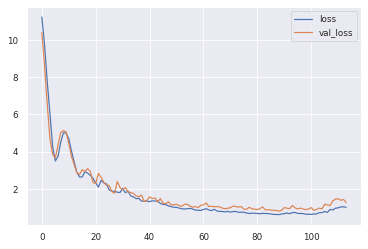

In [11]:
pd.read_csv("log.csv", sep=",")[['loss','val_loss']].plot()

In [12]:
model.evaluate(X_test, Y_test)

4/4 [==============================] - 0s 4ms/step - loss: 1.7215 - accuracy: 0.8760 - auc: 0.9399 - f1: 0.8828


[1.7214850187301636, 0.8760330677032471, 0.939940333366394, 0.8828124403953552]

In [0]:
model.save(f"model_{label}.h5")
#model = load_model(f"model_{label}.h5")

In [14]:
gc.collect()

23929

# evaluate on non used on topsbm training


In [20]:
classes = df_labels[label].unique()
np.savetxt("classes.txt", classes, fmt="%s")
np.savetxt("X_test.txt", X_test)
np.savetxt("Y_test.txt", Y_test)
print(X_test.shape, Y_test.shape)

(121, 147) (121, 4)


In [21]:
model.evaluate(X_test, Y_test, verbose=2, workers=-1, use_multiprocessing=True)

4/4 - 0s - loss: 1.7215 - accuracy: 0.8760 - auc: 0.9399 - f1: 0.8828


[1.7214850187301636, 0.8760330677032471, 0.939940333366394, 0.8828124403953552]

In [0]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns

In [0]:
y_pred_p = model.predict(X_test)
y_true = np.argmax(Y_test, axis=1)
y_pred = np.argmax(y_pred_p, axis=1)
results = confusion_matrix(y_true, y_pred, normalize="true")

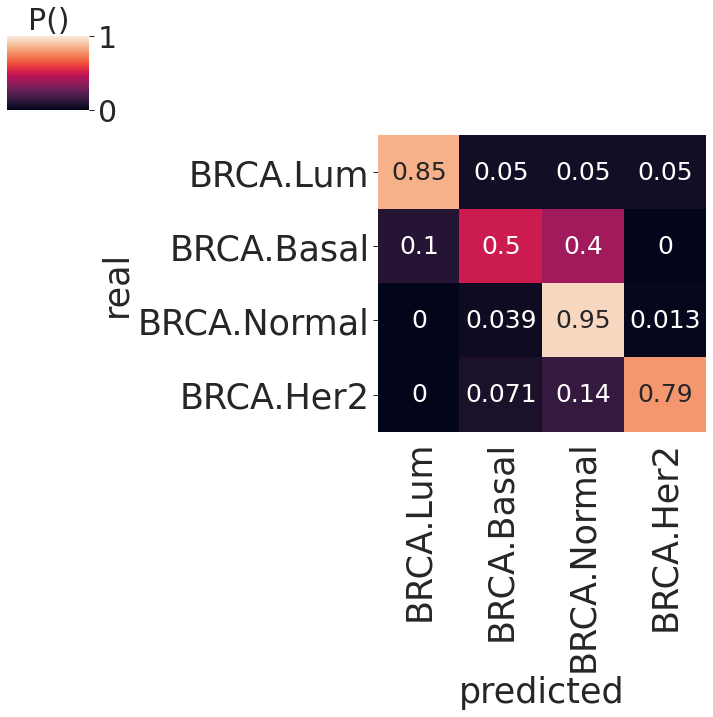

In [24]:
cm = sns.clustermap(results, 
                    vmax=1,  
                    row_cluster=False, 
                    col_cluster=False, 
                    xticklabels=classes, 
                    yticklabels=classes, 
                    annot=False,
                    annot_kws={"fontsize":25})
ax = cm.ax_heatmap
fig = ax.get_figure()
ax.set_ylabel("real", fontsize=35, rotation=90)
ax.set_yticklabels(labels=classes, rotation=0)
ax.yaxis.tick_left()
ax.yaxis.set_label_position("left")

ax.set_xticklabels(labels=classes, rotation=90)
ax.set_xlabel("predicted",fontsize=35)
ax.tick_params(labelsize=35)

cax = cm.ax_cbar
cax.tick_params(labelsize=30)
cax.set_title("P()", fontsize=30)
plt.tight_layout()
cm.savefig(f"predict_{label}.pdf")

plt.show()